In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_hub as hub
from absl import logging

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

## Read in and basic overview

In [3]:
# Read csv dataset
path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
df = pd.read_csv(path_dataset)
#df = pd.read_csv('Capital_Projects.csv')
#print(df.shape)
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] > 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)

# Minimize the effect of ZERO schedule change on regression model
new_df = df[df['Total Schedule Changes'] == 0].sample(n=15, random_state=1)
df = df[df['Total Schedule Changes'] != 0]
df = df.append(new_df)

# Minimize the effect of ZERO budget change on regression model
new_df = df[df['Total Budget Changes'] == 0].sample(n=7, random_state=1)
df = df[df['Total Budget Changes'] != 0]
df = df.append(new_df)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,301,301.000000,301,298,301,152,301,240,301,294,3.010000e+02,2.480000e+02,2.480000e+02,299,246.000000,246.000000
unique,4,NaN,301,277,21,19,12,29,5,256,NaN,NaN,NaN,252,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,Queens Water Main New Installations,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,12/31/2019,NaN,NaN
freq,240,NaN,1,16,63,41,152,105,144,7,NaN,NaN,NaN,11,NaN,NaN
mean,NaN,639.368771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.128818e+08,2.684097e+06,2.010676e+07,NaN,66.967480,562.239837
std,NaN,274.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.574745e+08,4.023569e+07,8.348361e+07,NaN,216.554972,657.996523
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.116642e+06,-2.664272e+08,-2.919002e+08,NaN,-995.000000,-1412.000000
25%,NaN,474.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.595827e+07,0.000000e+00,0.000000e+00,NaN,0.000000,86.500000
50%,NaN,656.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501760e+07,0.000000e+00,4.953144e+06,NaN,0.000000,450.000000
75%,NaN,868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.038300e+07,1.000000e+06,2.574161e+07,NaN,91.000000,944.250000


## NLP Embedding preparation

In [4]:
# Define list of stop words and a function to normalize text
nltk.download('stopwords')
stops = set(stopwords.words("english"))
stops = stops.union(['i','say','like','year','one','also','said','use'])

# Define tokenizer to split sentence into tokens
tokenizer = RegexpTokenizer(r'[a-z]+')

def textNormalize(text):
    textLower = text.lower()
    textList = tokenizer.tokenize(textLower)
    stopped_doc_tokens = [word for word in textList if not word in stops]
    stopstem_doc_tokens0 = [PorterStemmer().stem(word) for word in stopped_doc_tokens]
    stopstem_doc_tokens = [word for word in stopstem_doc_tokens0 if len(word)>1]
    return stopstem_doc_tokens

#example to check how it works
textNormalize(".. 120 I'm in Delhi India,,, today is 2019. went flying")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/smahabha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['delhi', 'india', 'today', 'went', 'fli']

In [5]:
df['Description'] = df['Description'].astype(str)
df['Normalized Description'] = df['Description'].apply(textNormalize)
df['normal_joined'] = df['Normalized Description'].apply(', '.join)
df['normal_joined'] = df['normal_joined'].apply(lambda x: x.replace(', ', ' '))
df.head(n=3)

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Normalized Description,normal_joined
12,09/01/2019 12:00:00 AM,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,09/23/2013,1.805777e+08,-4664980.0,-4318643.37,10/09/2020,0.0,270.0,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...
27,09/01/2019 12:00:00 AM,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,Construction,05/01/2013,6.879846e+07,1065884.0,15305457.00,02/14/2020,88.0,685.0,"[exist, main, sewag, pump, deterior, pump, sys...",exist main sewag pump deterior pump system inc...
42,09/01/2019 12:00:00 AM,18,Croton Falls Pumping Station Construction,This project will construct a new pumping stat...,Water Supply,Carmel,DEP,DEP,Construction,08/22/2003,6.787161e+07,-1399611.0,1255175.02,03/10/2020,91.0,1014.0,"[project, construct, new, pump, station, repla...",project construct new pump station replac hydr...


In [6]:
# Universal sentence encoder 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Data Transformation, Feature Engineering and Plots

In [7]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-08-01 00:00:00


Date Reported As Of        datetime64[ns]
PID                                 int64
Project Name                       object
Description                        object
Category                           object
Borough                            object
Managing Agency                    object
Client Agency                      object
Current Phase                      object
Design Start               datetime64[ns]
Budget Forecast                   float64
Latest Budget Changes             float64
Total Budget Changes              float64
Forecast Completion        datetime64[ns]
Latest Schedule Changes           float64
Total Schedule Changes            float64
Normalized Description             object
normal_joined                      object
dtype: object

In [8]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = df['Total Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1))

### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
df['Project Duration Norm'] = (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration)
df['Project Duration'] = df['Project Duration']/pd.Timedelta(days=1)
print(f'Max Project Duration: {max_project_duration} \n Min Project Duration: {min_project_duration} ')
df.describe(include='all')

Max Project Duration: 9736 days 00:00:00 
 Min Project Duration: 656 days 00:00:00 


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1648, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,...,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Normalized Description,normal_joined,Project Duration,Schedule Change Norm,Project Duration Norm
count,301,301.000000,301,301,301,152,301,240,301,294,...,2.480000e+02,2.480000e+02,299,246.000000,246.000000,301,301,293.000000,241.000000,293.000000
unique,4,NaN,301,278,21,19,12,29,5,256,...,NaN,NaN,252,NaN,NaN,271,271,NaN,NaN,NaN
top,2019-09-01 00:00:00,NaN,Queens Water Main New Installations,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,2016-05-04 00:00:00,...,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,"[design, construct, new, school]",design construct new school,NaN,NaN,NaN
freq,240,NaN,1,16,63,41,152,105,144,7,...,NaN,NaN,11,NaN,NaN,16,16,NaN,NaN,NaN
first,2018-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993-08-02 00:00:00,...,NaN,NaN,2019-03-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-30 00:00:00,...,NaN,NaN,2031-07-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,639.368771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.684097e+06,2.010676e+07,NaN,66.967480,562.239837,NaN,NaN,2773.535836,0.180054,0.233209
std,NaN,274.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.023569e+07,8.348361e+07,NaN,216.554972,657.996523,NaN,NaN,1418.030371,0.218157,0.156171
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.664272e+08,-2.919002e+08,NaN,-995.000000,-1412.000000,NaN,NaN,656.000000,-0.722620,0.000000
25%,NaN,474.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,NaN,0.000000,86.500000,NaN,NaN,1879.000000,0.037037,0.134692


/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


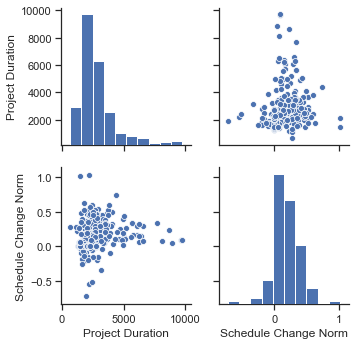

In [9]:

import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Project Duration', 'Schedule Change Norm']])

In [10]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
df['Budget Change Norm'] = df['Total Budget Changes']/df['Budget Forecast']

### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9 - 0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')


Max Budget: 2449621616.0 
 Min Budget: 2116642.0


### Remove Outliers

In [11]:
# Remove outliers
df = df[df['Budget Change Norm'] > -2]
df = df[df['Total Budget Norm'] < 0.3]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.describe(include='all')

Minimum Budget Change Norm: -1.9474624118003965


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1648, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,...,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Normalized Description,normal_joined,Project Duration,Schedule Change Norm,Project Duration Norm,Budget Change Norm,Total Budget Norm
count,235,235.000000,235,235,235,143,235,180,235,230,...,234,233.000000,233.000000,235,235,230.000000,230.000000,230.000000,235.000000,235.000000
unique,4,NaN,235,222,19,18,11,28,5,210,...,206,NaN,NaN,218,218,NaN,NaN,NaN,NaN,NaN
top,2019-09-01 00:00:00,NaN,Queens Water Main New Installations,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,2017-05-30 00:00:00,...,2019-12-31 00:00:00,NaN,NaN,"[design, construct, new, school]",design construct new school,NaN,NaN,NaN,NaN,NaN
freq,180,NaN,1,12,44,39,112,83,120,4,...,10,NaN,NaN,12,12,NaN,NaN,NaN,NaN,NaN
first,2018-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993-08-02 00:00:00,...,2019-06-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-20 00:00:00,...,2027-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,564.587234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,65.296137,548.008584,NaN,NaN,2872.856522,0.177726,0.244147,0.137055,0.126253
std,NaN,247.255975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,201.971731,652.755023,NaN,NaN,1440.048335,0.218598,0.158596,0.365015,0.025343
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-995.000000,-1412.000000,NaN,NaN,656.000000,-0.722620,0.000000,-1.947462,0.102606
25%,NaN,431.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,77.000000,NaN,NaN,1981.250000,0.033659,0.145953,0.000000,0.112166


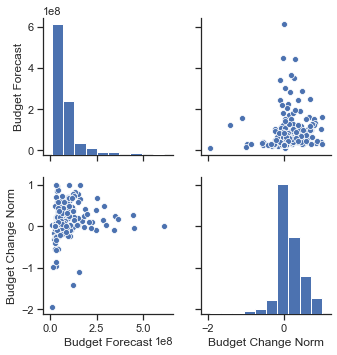

In [12]:
sns.set(style="ticks")
sns.pairplot(df[['Budget Forecast', 'Budget Change Norm']])

### Adding NLP embedded columns and running PCA to limit # of columns

In [13]:
# The embedding of the description is ready for use in Regression later
embedding = embed(df.normal_joined).numpy()
df_embed = pd.DataFrame(embedding)
from sklearn.decomposition import PCA
pca = PCA(n_components=45)
pc = pca.fit_transform(df_embed)
print(np.sum(pca.explained_variance_ratio_))#percent of variance explained by the the # pc axes chosen
df_pc = pd.DataFrame(pc)
# concatenate the columns related to embedding of project description (512 columns)
df = df.reset_index(drop=True).merge(df_pc.reset_index(drop=True), left_index=True, right_index=True)

0.76691836


### Adding Dummy variables and dropping categorical columns

In [14]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Total Budget Norm', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Project Duration Norm', 'Current Phase']
nyc_df = nyc_df.drop(drop_columns, axis=1)
# Log of both Project Duration and Budget Forecast
nyc_df['Budget Forecast'] = np.log(nyc_df['Budget Forecast'])
nyc_df['Project Duration'] = np.log(nyc_df['Project Duration'])

nyc_df.describe(include='all')

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1648, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


,Budget Forecast,Normalized Description,normal_joined,Project Duration,Schedule Change Norm,Budget Change Norm,0,1,2,3,...,"Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,235.000000,235,235,230.000000,230.000000,235.000000,2.350000e+02,2.350000e+02,235.000000,2.350000e+02,...,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
unique,NaN,218,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,"[design, construct, new, school]",design construct new school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,12,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,17.963800,NaN,NaN,7.867122,0.177726,0.137055,-2.536368e-08,-2.739277e-08,0.000000,1.344275e-08,...,0.004255,0.004255,0.004255,0.004255,0.004255,0.004255,0.127660,0.046809,0.008511,0.004255
std,0.679063,NaN,NaN,0.421443,0.218598,0.365015,2.761016e-01,2.413459e-01,0.196173,1.836039e-01,...,0.065233,0.065233,0.065233,0.065233,0.065233,0.065233,0.334423,0.211679,0.092056,0.065233
min,16.126891,NaN,NaN,6.486161,-0.722620,-1.947462,-4.745968e-01,-4.947550e-01,-0.415365,-4.332094e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.487651,NaN,NaN,7.591483,0.033659,0.000000,-2.072949e-01,-1.915821e-01,-0.136680,-1.263724e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.900327,NaN,NaN,7.818427,0.164496,0.089425,-2.109144e-02,-1.411550e-02,-0.029815,-8.132949e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.389448,NaN,NaN,8.108095,0.307498,0.326867,1.755145e-01,1.887010e-01,0.129263,1.395682e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Test Train Split

In [15]:
nyc_df = nyc_df.dropna()
np.random.seed(49)
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=49)

In [16]:
nyc_train.head()

,Budget Forecast,Normalized Description,normal_joined,Project Duration,Schedule Change Norm,Budget Change Norm,0,1,2,3,...,"Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
143,17.470601,"[construct, sanitari, storm, sewer, water, mai...",construct sanitari storm sewer water main appu...,7.609862,0.017344,0.112694,0.040072,-0.494755,0.267676,-0.123617,...,0,0,0,0,0,0,0,1,0,0
189,17.826474,"[bronx, suprem, court, fire, alarm, sprinkler,...",bronx suprem court fire alarm sprinkler grand ...,7.604894,0.047311,0.217747,0.222032,-0.217541,0.130369,0.087075,...,0,0,0,0,0,0,0,0,0,0
68,18.644799,"[introduc, bu, rapid, transit, brt, treatment,...",introduc bu rapid transit brt treatment along ...,8.248267,0.599843,0.785818,-0.216025,-0.026120,-0.297352,-0.229728,...,0,0,0,0,0,0,0,0,0,0
146,16.655380,"[project, provid, armor, kensico, reservoir, s...",project provid armor kensico reservoir shoreli...,7.884577,0.186747,-0.990587,0.158850,-0.369560,-0.058165,0.071134,...,0,0,0,0,0,0,0,0,0,1
8,19.318951,"[instal, two, independ, concret, steel, struct...",instal two independ concret steel structur rep...,8.641532,0.334511,-0.101069,-0.032539,-0.100021,-0.107126,-0.123099,...,0,0,0,0,0,0,0,0,0,0


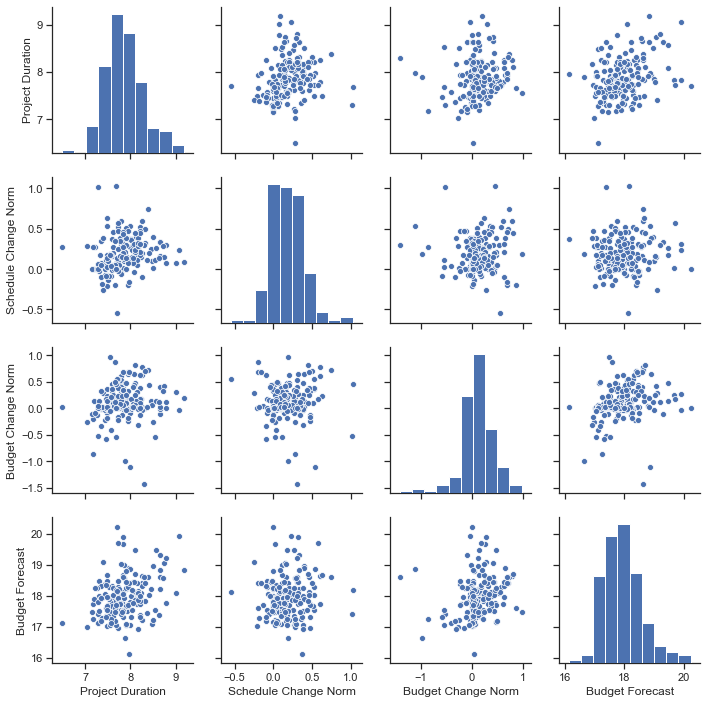

In [17]:
qual_columns = ['Project Duration',	'Schedule Change Norm',
                'Budget Change Norm',	'Budget Forecast']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])

In [18]:
nyc_train[qual_columns].corr()

,Project Duration,Schedule Change Norm,Budget Change Norm,Budget Forecast
Project Duration,1.000000,0.214201,0.128966,0.333067
Schedule Change Norm,0.214201,1.000000,0.031696,0.074583
Budget Change Norm,0.128966,0.031696,1.000000,0.235561
Budget Forecast,0.333067,0.074583,0.235561,1.000000


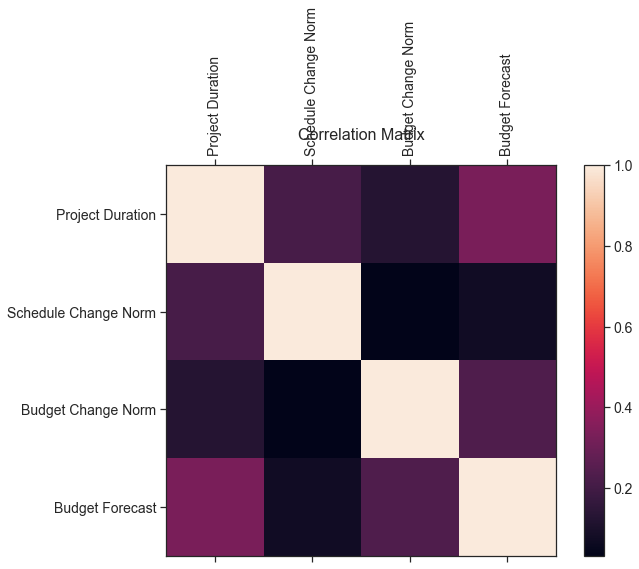

In [19]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Regression - Linear Regression, Lasso and Ridge

In [20]:
# Budget change
# 'Project Duration', 'Schedule Change Norm', 'Total Budget Norm', 'Budget Change Norm'
nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = (nyc_train_trunc['Budget Change Norm'])
X_train = nyc_train_trunc.drop(['Budget Change Norm', 'Project Duration'], axis=1)
# Remove redundant columns: found through VIF (multi-collinearity analysis in below cell)

drop_mc_columns = ['Category_Health and Hospitals, IT', 'Category_IT', 'Category_Industrial Development, Parks',
                   'Category_Industrial Development, Streets and Roadways', 'Category_Libraries', 
                   'Borough_Brooklyn, Queens','Borough_Manhattan, Staten Island, Bronx', 'Borough_Olive',
                   'Borough_Marlboro', 'Borough_Port Jervis', 'Borough_New York', 
                   'Borough_Carmel','Category_Streets and Roadways', 
                  'Normalized Description', 'normal_joined']
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')

# No need for polynomial interactions - doesn't improve score
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)

# No need for increasing polynomial terms - decreases the test scores
#X_train['Budget_2T'] = X_train['Budget Forecast'] * X_train['Budget Forecast']
#X_train['Budget_3T'] = X_train['Schedule Change Norm'] * X_train['Budget Forecast']
#X_train['Project_2T'] = X_train['Project Duration'] * X_train['Project Duration']

lr_cost_model = LinearRegression().fit(X_train, y_train)
lr_cost_model.score(X_train, y_train)
alphas = (0.1, 0.5,1,5,10,50,100)
ridge_cost_model = RidgeCV(alphas=alphas,normalize=True, cv=10).fit(X_train, y_train)
lasso_cost_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)

print(f'LinearRegression score: {lr_cost_model.score(X_train, y_train)}')
print(f'Lasso score: {lasso_cost_model.score(X_train, y_train)}')
print(f'Ridge score: {ridge_cost_model.score(X_train, y_train)}')

LinearRegression score: 0.49173238848782225
Lasso score: 0.0
Ridge score: 0.1500357076677541


In [21]:
nyc_test_trunc = nyc_test.copy()
#nyc_test_trunc = nyc_test_trunc[qual_columns]
y_test = nyc_test_trunc['Budget Change Norm']
X_test = nyc_test_trunc.drop(['Budget Change Norm', 'Project Duration'], axis=1)
X_test = X_test.drop(drop_mc_columns, axis=1, errors='ignore')
testr2 = lr_cost_model.score(X_test, y_test)

In [22]:
print(f'The best test r-squared value so far is {testr2}')

The best test r-squared value so far is 0.3042189170371449


### Bagging Techniques

In [23]:
# BAGGING TECHNIQUES
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
num_bags = 10
np.random.seed(49)
bagging_train = np.zeros((X_train.shape[0], num_bags))
bagging_test = np.zeros((X_test.shape[0], num_bags))
bagging_models = []
for i in range(num_bags):
  bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
  fitted_model = RidgeCV(alphas=alphas,normalize=True, cv=5).fit(bootstrapped_X, bootstrapped_y)
  bagging_models.append(fitted_model)
  bagging_train[:,i] = fitted_model.predict(X_train)
  bagging_test[:,i] = fitted_model.predict(X_test)

bagging_train_predicts = np.mean(bagging_train[:,:], axis=1)
bagging_test_predicts = np.mean(bagging_test[:,:], axis=1)
print(f'Training score: {mean_squared_error(y_train, bagging_train_predicts)}')
print(f'Test score: {mean_squared_error(y_test, bagging_test_predicts)}')

Training score: 0.07425854000440765
Test score: 0.16913768384904618


In [24]:
X_train_ols = sm.add_constant(X_train)
results = OLS(y_train, X_train_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     1.526
Date:                Thu, 07 May 2020   Prob (F-statistic):             0.0225
Time:                        23:59:48   Log-Likelihood:                 9.8740
No. Observations:                 184   AIC:                             124.3
Df Residuals:                     112   BIC:                             355.7
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.8470      0.872     -2.119      0.036      -3.574      -0.120
Budget Forecast                                 0.1086      0.049      2.213      0.029       0.011       0.206
Schedule Change Norm                            0.1274      0.139      0.916      0.362      -0.148       0.403
0                                               0.1942      0.236      0.823      0.412      -0.274       0.662
1                                               0.3430      0.239      1.437      0.153      -0.130       0.816
2                                               0.2866      0.237      1.212      0.228      -0.182       0.755
3                                              -0.4410      0.261     -1.689      0.094      -0.958       0.076
4                                              -0.5031      0.186     -2.702      0.008      -0.872      -0.134
5                                              -0.0440      0.215     -0.205      0.838      -0.471       0.383
6                                               0.0727      0.217      0.335      0.738      -0.357       0.502
7                                               0.0775      0.232      0.334      0.739      -0.382       0.537
8                                              -0.4968      0.239     -2.076      0.040      -0.971      -0.023
9                                              -0.0879      0.232     -0.378      0.706      -0.548       0.372
10                                              0.0083      0.240      0.034      0.973      -0.468       0.484
11                                             -0.2813      0.291     -0.968      0.335      -0.857       0.295
12                                             -0.0472      0.250     -0.188      0.851      -0.543       0.449
13                                             -0.5340      0.283     -1.884      0.062      -1.096       0.028
14                                              0.2351      0.274      0.857      0.393      -0.309       0.779
15                                             -0.1756      0.256     -0.687      0.494      -0.682       0.331
16                                             -0.2740      0.321     -0.852      0.396      -0.911       0.363
17                                             -0.4289      0.265     -1.617      0.109      -0.954       0.097
18                                             -0.0720      0.287     -0.251      0.802      -0.641       0.497
19                                             -0.1995      0.263     -0.760      0.449      -0.720       0.321
20                                              0.2778      0.316      0.878      0.382      -0.349       0.905
21                                              0.2214     

In [25]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

Budget Forecast          14.869360
Schedule Change Norm      3.222509
0                         8.368144
1                         6.787658
2                         4.716107
                           ...    
Borough_Manhatten         1.465445
Borough_Queens            1.840053
Borough_Staten Island     1.967447
Borough_Upstate           1.847215
Borough_Valhalla          1.829873
Length: 71, dtype: float64

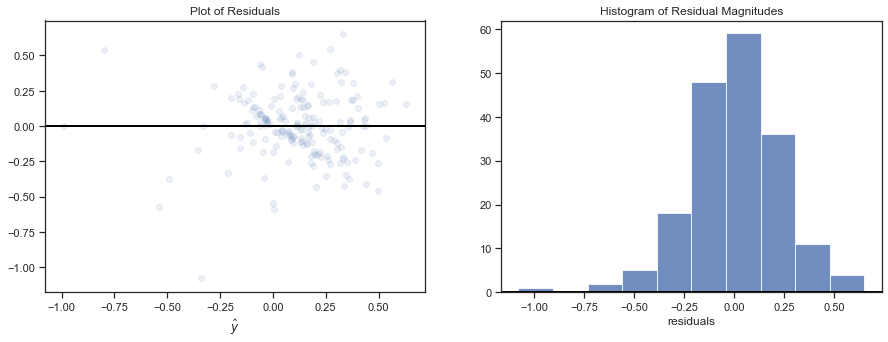

In [26]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


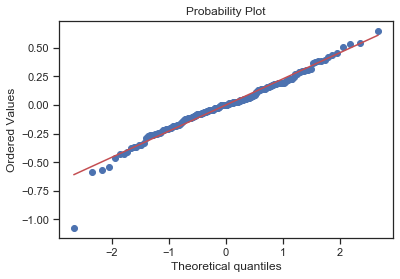

In [27]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

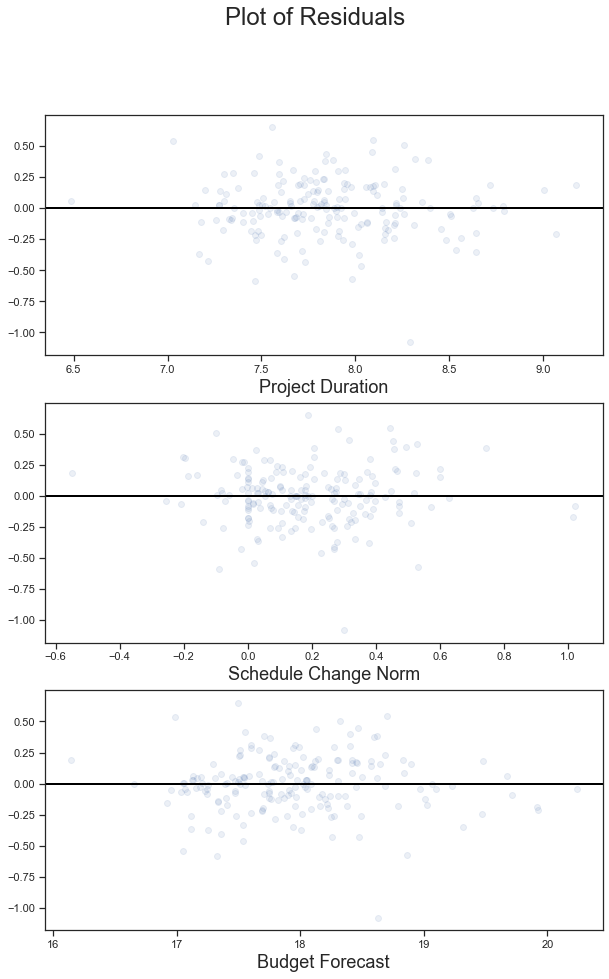

In [28]:
# Residual Plots
X_colms = ['Project Duration','Schedule Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

In [29]:
# Schedule change
nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = (nyc_train_trunc['Schedule Change Norm'])
X_train = nyc_train_trunc.drop(['Schedule Change Norm'], axis=1)
# Remove redundant columns: found through VIF (multi-collinearity analysis in below cell)
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')
lr_time_model = LinearRegression().fit(X_train, y_train)
ridge_time_model = RidgeCV(alphas=alphas,normalize=True, cv=10).fit(X_train, y_train)
lasso_time_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)

print(f'LinearRegression score: {lr_time_model.score(X_train, y_train)}')
print(f'Lasso score: {lasso_time_model.score(X_train, y_train)}')
print(f'Ridge score: {ridge_time_model.score(X_train, y_train)}')

LinearRegression score: 0.4678759576494408
Lasso score: 0.0
Ridge score: 0.1597291692123215


In [30]:
y_test = nyc_test_trunc['Schedule Change Norm']
X_test = nyc_test_trunc.drop(['Schedule Change Norm'], axis=1)
X_test = X_test.drop(drop_mc_columns, axis=1, errors='ignore')
ridge_time_model.score(X_test, y_test)

0.012892710207023761

In [31]:
X_train_ols = sm.add_constant(X_train)
results = OLS(y_train, X_train_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.468
Model:                              OLS   Adj. R-squared:                  0.123
Method:                   Least Squares   F-statistic:                     1.356
Date:                  Thu, 07 May 2020   Prob (F-statistic):             0.0742
Time:                          23:59:51   Log-Likelihood:                 81.729
No. Observations:                   184   AIC:                            -17.46
Df Residuals:                       111   BIC:                             217.2
Df Model:                            72                                         
Covariance Type:              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           0.9610      0.659      1.457      0.148      -0.346       2.268
Budget Forecast                                -0.0487      0.036     -1.363      0.176      -0.120       0.022
Project Duration                                0.0037      0.062      0.059      0.953      -0.120       0.127
Budget Change Norm                              0.0586      0.064      0.914      0.363      -0.068       0.186
0                                               0.0008      0.162      0.005      0.996      -0.320       0.321
1                                              -0.0383      0.164     -0.234      0.815      -0.363       0.286
2                                              -0.1515      0.161     -0.939      0.350      -0.471       0.168
3                                              -0.1368      0.179     -0.763      0.447      -0.492       0.218
4                                               0.1012      0.133      0.759      0.450      -0.163       0.366
5                                              -0.1339      0.151     -0.889      0.376      -0.432       0.164
6                                               0.2206      0.146      1.510      0.134      -0.069       0.510
7                                              -0.0238      0.158     -0.151      0.880      -0.336       0.288
8                                               0.1497      0.167      0.897      0.372      -0.181       0.481
9                                               0.2694      0.157      1.715      0.089      -0.042       0.581
10                                             -0.2093      0.162     -1.292      0.199      -0.530       0.112
11                                              0.0529      0.200      0.265      0.791      -0.343       0.448
12                                              0.0320      0.170      0.187      0.852      -0.306       0.370
13                                             -0.1336      0.195     -0.684      0.496      -0.521       0.254
14                                             -0.4109      0.185     -2.218      0.029      -0.778      -0.044
15                                              0.2156      0.180      1.198      0.234      -0.141       0.572
16                                              0.2900      0.218      1.333      0.185      -0.141       0.721
17                                              0.1110      0.182      0.610      0.543      -0.250       0.472
18                                              0.1371      0.195      0.703      0.484      -0.249       0.524
19                                              0.1811      0.178      1.016      0.312      -0.172       0.534
20                                   

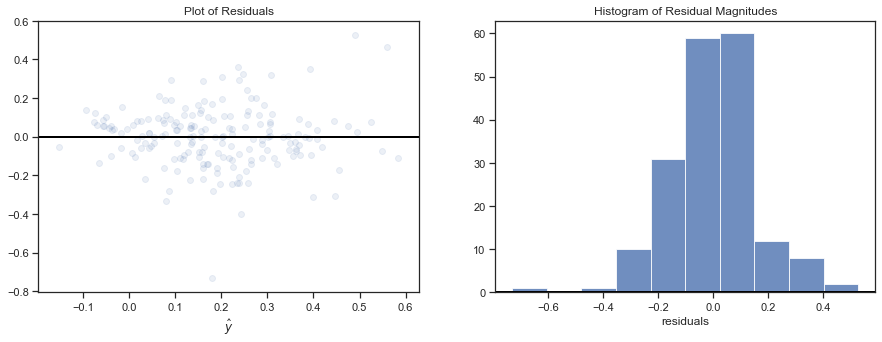

In [32]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

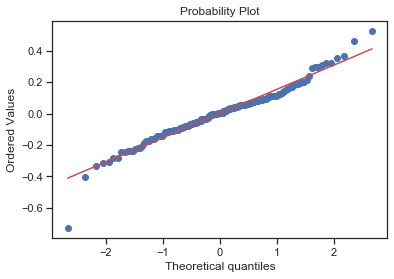

In [33]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

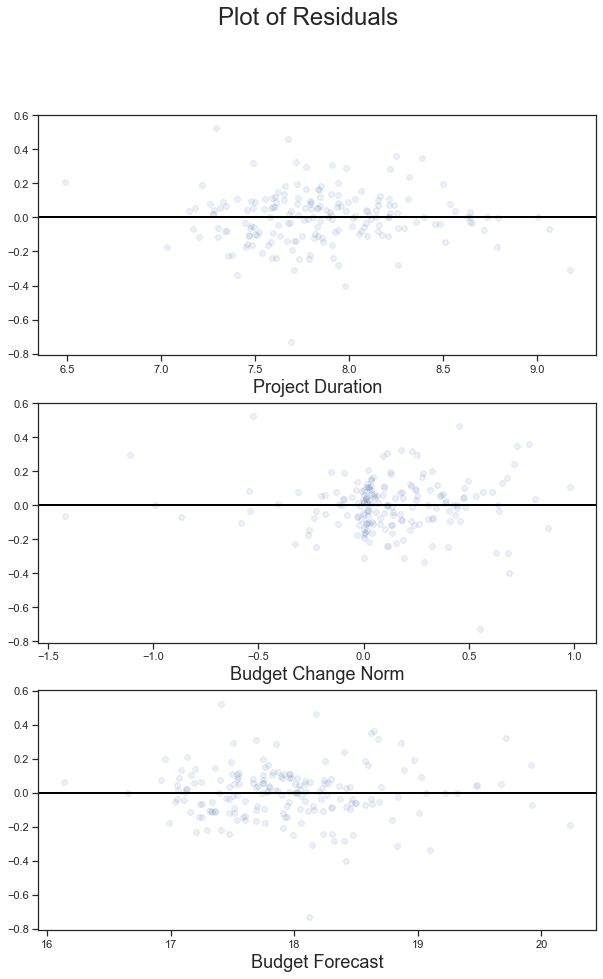

In [34]:
# Residual Plots
X_colms = ['Project Duration','Budget Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

#### GAM Model

In [35]:
!pip install pygam
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

In [36]:
smoothings = np.logspace(-3, 6, 9)
cv = 10
from sklearn.model_selection import KFold

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

print(smoothings,'\n')
print(scores.shape, '\n')


[1.00000000e-03 1.33352143e-02 1.77827941e-01 2.37137371e+00
 3.16227766e+01 4.21696503e+02 5.62341325e+03 7.49894209e+04
 1.00000000e+06] 

(10, 9) 



In [37]:
y_train = pd.DataFrame(nyc_train['Budget Change Norm'])
X_train = nyc_train[qual_columns].drop('Budget Change Norm', axis=1)

In [38]:
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    test_df = X_train.iloc[test_index,:]
    train_y = y_train.iloc[train_index,:]
    test_y = y_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(s(0) + s(1) + s(2), lam = smoothing).fit(train_df, train_y)
        scores[i,j] = r2_score(test_y, cur_model.predict(test_df))
                              
best_lambda = smoothings[np.argmax(np.mean(scores, axis = 0))]
best_lambda

421.6965034285823

In [39]:
nyc_gam1 = LinearGAM(s(0) + s(1) + s(2), lam=best_lambda).fit(X_train, y_train)
r_score_train = r2_score(y_train, nyc_gam1.predict(X_train))

X_test = nyc_test[qual_columns].drop('Budget Change Norm', axis=1)
y_test = nyc_test['Budget Change Norm']
r_score_test = r2_score(y_test, nyc_gam1.predict(X_test))


print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(nyc_gam1.summary())


###########################################################

Lambda = 421.697
Training R-Squared = 0.14320
Testing R-Squared = 0.15883

###########################################################

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.5538
Link Function:                     IdentityLink Log Likelihood:                                  -695.0519
Number of Samples:                          184 AIC:                                             1405.2113
                                                AICc:                                            1405.9479
                                                GCV:                                                0.0982
                                                Scale

/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


#### K-neighbors

In [40]:
# K-neigbors 
k_values = [3, 5, 10, 15, 20]
# build a dictionary KNN models
KNNModels = {k: KNeighborsRegressor(n_neighbors=k) for k in k_values}
# fit each KNN model
for k_value in KNNModels:
KNNModels[k_value].fit(train_data[['TimeMin']], train_data[['PickupCount'
]])

IndentationError: expected an indented block (<ipython-input-40-8b73b5f4e75a>, line 7)